# Shadow on my solar panels

In this notebook I estimate the effect of shadow on the yield of my solar panels.

First some imports:

In [1]:
from typing import Optional, List, Union

from matplotlib.pyplot import Axes, cm, subplots
from numpy import arccos, cos, sin, linspace
from pandas import read_json, DataFrame
from pandas import DataFrame

We start off with a dataset of power measurements, at an interval of 10 minutes, to which I've added the
azimuth and altitude of the sun at those moments.

In [2]:
power_df = read_json("clean.json")
power_df.head()

,power,azimuth,altitude
2019-12-01 00:00:00,0.0,-165.789385,-59.031945
2019-12-01 00:10:00,0.0,-161.384245,-58.599296
2019-12-01 00:20:00,0.0,-157.085368,-58.056165
2019-12-01 00:30:00,0.0,-152.909523,-57.408479
2019-12-01 00:40:00,0.0,-148.869018,-56.662811


Also, we have a dataset of weather conditions at my house. We're mainly interested in the temperature and cloud
cover. I'm reindexing those such that we can join them with the power measurements.

In [3]:
weather_df = (
    read_json("weather.json")
    .set_index('date').sort_index()
    .reindex(index=power_df.index, method="ffill")
    [["temperature", "cloud_cover"]]
)
weather_df.head()

,temperature,cloud_cover
2019-12-01 00:00:00,-1.9,0.8
2019-12-01 00:10:00,-1.9,0.8
2019-12-01 00:20:00,-1.9,0.8
2019-12-01 00:30:00,-1.9,0.8
2019-12-01 00:40:00,-1.9,0.8


While the altitude and azimuth are useful, the angle of the sun with respect to the solar panels is
much more interesting. So after joining the power and weather data, we add the incidence (the angle of the sun
with respect to the panels), the insolence (the cosine of the angle of the sun with respect to the earth) and the
incidence factor (the cosine of the incidence).

We define that there is a clear sky when the rolling mean of the cloud cover < 10% over a window of an hour.

In [4]:
def compute_incidence(df: DataFrame, panel_azimuth: float, panel_altitude: float) -> DataFrame:
    radian_factor = 0.01745329
    return df.assign(
        incidence=lambda d: arccos(
            (
                sin((90 - d.altitude) * radian_factor)
                * cos(d.azimuth * radian_factor)
                * sin((90 - panel_altitude) * radian_factor)
                * cos(panel_azimuth * radian_factor)
                + sin((90 - d.altitude) * radian_factor)
                * sin(d.azimuth * radian_factor)
                * sin((90 - panel_altitude) * radian_factor)
                * sin(panel_azimuth * radian_factor)
                + cos((90 - d.altitude) * radian_factor) * cos((90 - panel_altitude) * radian_factor)
            )
        )
        / radian_factor,
        insolence=lambda d: cos((90 - d.altitude) * radian_factor),
    ).assign(incidence_factor=lambda d: cos(d.incidence * radian_factor))


df = compute_incidence(
    power_df.join(weather_df),
    panel_altitude=34, 
    panel_azimuth=-84
).assign(
    # Take a rolling mean over the cloud cover to ensure that "no clouds" is really "no clouds"
    rm_cloud_cover=lambda d: d.rolling(window=6, center=True, min_periods=1)["cloud_cover"].mean()
).loc[lambda d: d.altitude > 0].assign(
    is_clear=lambda d: d.rm_cloud_cover < 0.10  
).loc[lambda d: d.power > 0]  # We're not interested in any data points at night

df.head()

,power,azimuth,altitude,temperature,cloud_cover,incidence,insolence,incidence_factor,rm_cloud_cover,is_clear
2019-12-31 10:50:00,0.115185,-12.503096,13.980160,6.6,0.8,67.020610,0.241586,0.390400,0.8,False
2019-12-31 11:00:00,0.233333,-10.153787,14.280859,8.0,0.8,68.809899,0.246675,0.361464,0.8,False
2019-12-31 11:10:00,0.164444,-7.794046,14.519781,8.0,0.8,70.636882,0.250714,0.331554,0.8,False
2019-12-31 11:20:00,0.134074,-5.426175,14.696252,8.0,0.8,72.498675,0.253695,0.300728,0.8,False
2019-12-31 11:30:00,0.144444,-3.052576,14.809767,8.0,0.8,74.392625,0.255611,0.269044,0.8,False


In [5]:
def plot_grid(
    df: DataFrame, column: str, ax: Optional[Axes] = None, resolution: int = 4, q=0.50, title=None, sz: int = 60
):
    agg = df.assign(
        azimuth=lambda x: x.azimuth.apply(lambda v: resolution * int(v / resolution)),
        altitude=lambda x: x.altitude.apply(lambda v: resolution * int(v / resolution)),
    ).groupby(["azimuth", "altitude"], as_index=False)[[column]]
    if isinstance(q, float):
        agg = agg.quantile(q=q)
    else:
        agg = agg.mean()
    ax = agg.plot(kind="scatter", x="azimuth", y="altitude", c=column, cmap=cm.rainbow, ax=ax, s=sz, alpha=0.75)
    ax.set_xlabel("azimuth")
    if title:
        ax.set_title(title)
    ax.set_xlim([-180, 180])

Here are some plots that can give us some insight in the data.

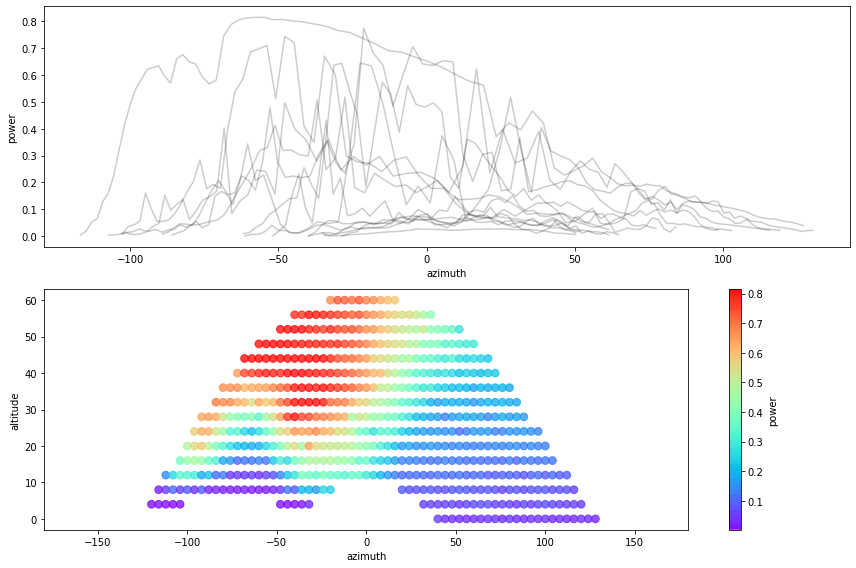

In [6]:
fig, axes = subplots(2, 1, figsize=(12, 8))
for dt, sdf in (
    df
    .assign(date=lambda d: d.index.date)
    .groupby("date")
    
):
    if str(dt).endswith("-01"):
        sdf.set_index("azimuth")["power"].plot(ax=axes[0], color='k', alpha=0.2)
axes[0].set_ylabel("power")
plot_grid(df, "power", ax=axes[1], q=0.95)
fig.tight_layout()

The top plot shows a number of power curves (the power is normalized to the peak power of all panels) for a number of days across the year. We can clearly see the difference between winter and summer days, we see that not a single day has a smooth curve (welcome to Dutch weather). We can also clearly see that the power is higher in the morning (azimuth < 0) - which makes sense because the panels are facing East.

The bottom plot shows the maximum power recorded in each segment of the sky - taking the maximum gets rid of (most) cloudy data. We can clearly see the silhouette of the neighboring house, which has a gable roof that is rotated 90 degrees: we are looking at one end. At the bar on the right we can see that the yield never goes beyond roughly 80% of the peak power: the limiting factor here is the inverter. It is common practice to under-dimension the inverter to save costs.

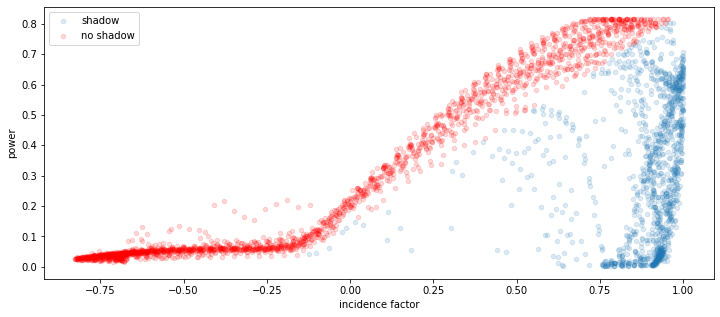

In [7]:
prepared = (
    df
    # This selection was made by hand
    .assign(shadow=lambda d: d.incidence_factor + 0.20 > d.power / 0.70)
)
fig, axes = subplots(figsize=(12, 5))
(
    prepared.loc[lambda d: d.shadow].loc[lambda d: d.is_clear]
    .plot(kind="scatter", x="incidence_factor", y="power", 
          alpha=0.15, ax=axes, label='shadow')
)
(
    prepared.loc[lambda d: ~d.shadow].loc[lambda d: d.is_clear]
    .plot(kind="scatter", x="incidence_factor", y="power", 
          alpha=0.15, ax=axes, color="red", label="no shadow")
)
_ = axes.set_xlabel("incidence factor")

Next we’ll try to model the power output of the solar panels as a function of the location of the sun. In order to keep it simple we’ll first only look at data from moments at which the sky was clear - according to the KNMI. Above is a plot of the incidence factor versus the power output. As we expect the power increases with the incidence factor: more sunlight on the panels means more power.

On the right we see quite a few points that are below the trend line - I’ve marked them blue. This is where the solar panels are in the shadow of the other house. We will ignore these points for now. I have also removed all points where the inverter was at its limit: these points would introduce a non-linearity I’d rather not deal with.

### Modelling indirect light

On the left of the plot above we see that even if there is no direct sunlight on the solar panels (the incidence factor < 0), there is still some power yield. This comes from indirect sunlight, reflected by the sky or some object. We do see that this goes down at the far end, where the sun nearly sets. It turns out that this indirect power can be modeled fairly accurately using only the altitude: if the sun is high in the sky, there is more indirect light.

In [8]:
from numpy import sqrt as np_sqrt
from statsmodels.formula.api import ols


def fit_indirect_model(df: DataFrame, clear=True, max_power=0.08) -> DataFrame:
    fit_df = (
        df
        .loc[lambda d: d.is_clear if clear else ~d.is_clear]
        .loc[lambda d: ~d.shadow]
        .loc[lambda d: d.power < max_power]
        .loc[lambda d: d.incidence_factor < -0.2]
    )
    
    indirect_model = ols(
        "power ~ insolence + np_sqrt(insolence) + temperature",
        fit_df
    ).fit()
    
    return (
        df
        .assign(indirect_prediction=lambda d: indirect_model.predict(d))
        # This is what would remain for the direct component
        .assign(direct=lambda d: d.power - d.indirect_prediction)
    )

If we fit a statsmodels OLS on the indirect data points (as shows below on the left), with the model
```power ~ insolence + np_sqrt(insolence) + temperature```
then we get the results show below on the right. This is a fairly good fit.

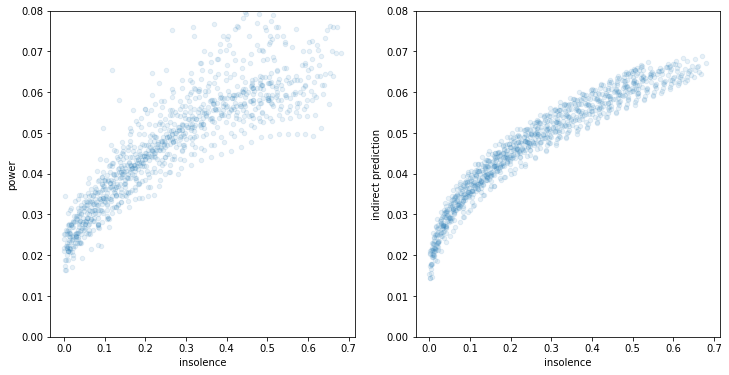

In [9]:
predictions_indirect = fit_indirect_model(prepared)

fig, axes = subplots(1, 2, figsize=(12, 6))
for y, ax in zip(("power", "indirect_prediction"), axes):
    (
        predictions_indirect
        .loc[lambda d: d.is_clear]
        .loc[lambda d: d.power < 0.08]
        .loc[lambda d: d.incidence_factor < 0.2]
        .plot(kind="scatter", x="insolence", y=y, alpha=0.1, ax=ax)
    )
    ax.set_ylim([0, 0.08])
    ax.set_ylabel(y.replace("_", " "))

Even when there is direct sunlight on a solar panel, part of the generated power will come from indirect light. If we assume this part to be independent
of the incidence angle, we can compute the contribution from direct light by estimating the contribution from indirect light using the model above,
and subtracting that from the actual power.

As I've applied the indirect model to all data points to get predictions, even those that have direct irradiation,
we can fit a model for direct light on the difference between the actual power and the indirect prediction.

Naively one might expect the contribution of direct light to be zero when the incidence factor equals zero, but
it appears that the effect "direct" light starts kicking in when the incidence factor is around -0.13,
as can also be seen in the plot below on the left.

In [10]:
from numpy import power as np_power


def fit_direct_model(df: DataFrame, cutoff=-0.13, clear=True) -> DataFrame:
    fit_df = (
        df
        .assign(
            incidence_factor_cutoff=lambda d: d.incidence_factor.where(lambda x: x > cutoff, cutoff) - cutoff
        )
        .loc[lambda d: d.is_clear if clear else ~d.is_clear]
        .loc[lambda d: d.power <= 0.80]
    )
    
    direct_model = ols(
        "direct ~ incidence_factor_cutoff + np_power(incidence_factor_cutoff, 2) + temperature",
        fit_df.loc[lambda d: ~d.shadow]
    ).fit()
    
    return (
        df
        .assign(direct_prediction=direct_model.predict(fit_df))
        .assign(prediction=lambda d: d.indirect_prediction + d.direct_prediction)
    )

Again the results on the right are from a statsmodels OLS fit, this time on the model `direct ~ incidence_factor_cutoff + np_power(incidence_factor_cutoff, 2) + temperature`, where `direct` is the power minor the indirect component, and `incidence_factor_cutoff` is the incidence factor minus the cutoff (-0.13). 

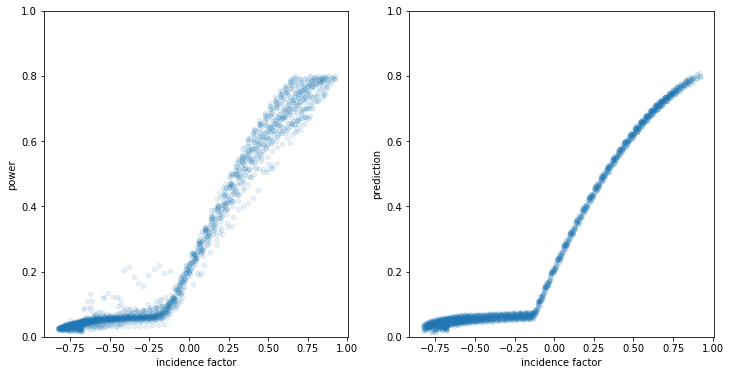

In [11]:
predictions_direct = fit_direct_model(predictions_indirect)

fig, axes = subplots(1, 2, figsize=(12, 6))
for y, ax in zip(("power", "prediction"), axes):
    (
        predictions_direct
        .loc[lambda d: d.is_clear]
        .loc[lambda d: d.power <= 0.80]
        .loc[lambda d: ~d.shadow]
        .plot(kind="scatter", x="incidence_factor", y=y, alpha=0.1, ax=ax)
    )
    ax.set_ylim([0, 1])
    ax.set_xlabel("incidence factor")
    ax.set_ylabel(y.replace("_", " "))

## Shadow

Now that we have a model describing the power yield of the solar panels in an ideal situation (with a clear sky, no shadow), we can
use that to make a model of the shadow. We define `power / predicted_power` as a measure for shadow - of course taking only data with
a clear sky - and train a random forest to predict the shadow as a function of azimuth and altitude. 

In [12]:
from sklearn.ensemble import RandomForestRegressor


def quantile_in_bins(
    df: DataFrame, by: Union[str, List[str]], columns: List[str], resolution: float = 1, quantile: float = 0.5
) -> DataFrame:
    if isinstance(by, str):
        by = [by]
    for column in by:
        df = df.assign(**{column: lambda d: (d[column] / resolution).astype(int) * resolution})
    return df.groupby(by, as_index=False)[columns].quantile(q=quantile)


def fit_shadow_model(df: DataFrame) -> DataFrame:
    fit_df = (
        df
        .loc[lambda d: d.is_clear]
        .loc[lambda d: d.power <= 0.80]
        .loc[lambda d: d.index.year == 2020]
        .pipe(
            quantile_in_bins,
            by=["altitude", "azimuth"],
            columns=["power", "prediction"],
            resolution=2,
            quantile=0.5,
        )
        .assign(shadow=lambda x: 1 - (x.power / x.prediction).clip(lower=0, upper=1))
        .dropna()
    )
    
    shadow_model = RandomForestRegressor().fit(fit_df[["altitude", "azimuth"]], fit_df["shadow"])
    example_data = (
        DataFrame(
            [
                dict(azimuth=azimuth, altitude=altitude)
                for azimuth in linspace(-150, 150, num=100)
                for altitude in linspace(0, 60, num=100)
            ]
        )[["altitude", "azimuth"]]
        .assign(shadow=lambda d: shadow_model.predict(d[["altitude", "azimuth"]]))
    )
    fig, axes = subplots(1, 1, figsize=(12, 3))
    plot_grid(example_data, "shadow", ax=axes)
    fig.tight_layout()
    return df.assign(shadow=lambda d: shadow_model.predict(df[["altitude", "azimuth"]]))

This is the result. Again we can clearly see the silhouette of the neighboring house, as well as a little bit of shadow caused by the exhaust of the ventilation system immediately South of the solar panels. 

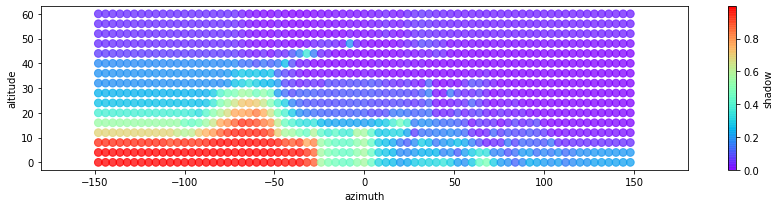

In [13]:
predictions_shadow = fit_shadow_model(predictions_direct)

Now we can also make an estimate of the total yield loss caused by the shadow: this is simply the total difference
between the predictions and the actual power. Of course we can only do this for moments the sky was clear:

In [14]:
clear_diff = (
    predictions_shadow
    .loc[lambda d: d.is_clear]
    .loc[lambda d: d.index.year == 2020]
    .assign(difference=lambda d: (d.prediction - d.power)/6).sum()
    ["difference"] * 2.700
)
print(f"The shadow resulted in {clear_diff:1.0f} kWh less yield in 2020.")

The shadow resulted in 250 kWh less yield in 2020.


### Cloudy

Now that we have an actual model for the shadow - not just a rule that works only with a clear sky,
we can repeat the entire analysis for cloudy skies:

In [15]:
input_cloudy = (
    predictions_shadow.assign(shadow=lambda d: d.shadow > 0.1)
    .loc[lambda d: ~d.is_clear]
    .loc[lambda d: d.altitude > 0.2]
)
predictions_cloudy_indirect = fit_indirect_model(input_cloudy, clear=False, max_power=0.15)
predictions_cloudy_direct = fit_direct_model(predictions_cloudy_indirect, clear=False)

The fits are less nice, but they work. Here for indirect:

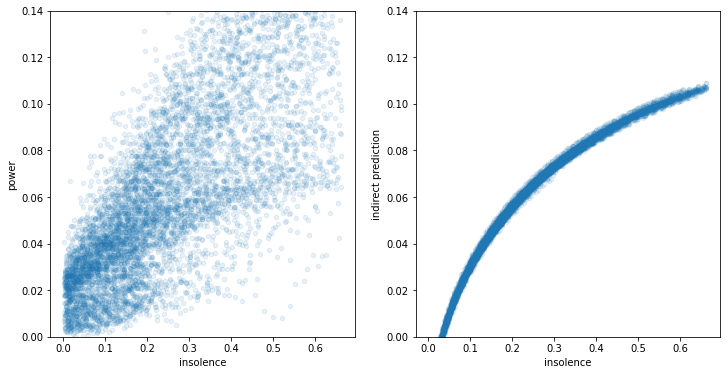

In [16]:
fig, axes = subplots(1, 2, figsize=(12, 6))
for y, ax in zip(("power", "indirect_prediction"), axes):
    (
        predictions_cloudy_indirect
        .loc[lambda d: ~d.is_clear]
        .loc[lambda d: d.power < 0.15]
        .loc[lambda d: d.incidence_factor < -0.2]
        .plot(kind="scatter", x="insolence", y=y, alpha=0.1, ax=ax)
    )
    ax.set_ylim([0, 0.14])
    ax.set_ylabel(y.replace("_", " "))

And for direct:

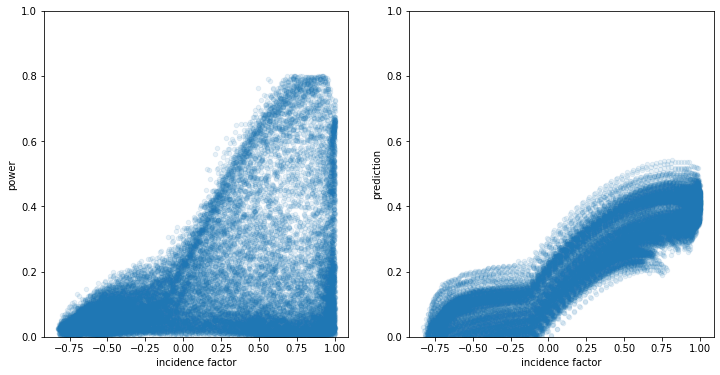

In [17]:
fig, axes = subplots(1, 2, figsize=(12, 6))
for y, ax in zip(("power", "prediction"), axes):
    (
        predictions_cloudy_direct
        
        .loc[lambda d: ~d.is_clear]
        .loc[lambda d: d.power <= 0.80]

        .plot(kind="scatter", x="incidence_factor", y=y, alpha=0.1, ax=ax)
    )
    ax.set_ylim([0, 1])
    ax.set_xlabel("incidence factor")
    ax.set_ylabel(y.replace("_", " "))

Looking only at cloudy moments when shadow did not come into play, we see hardly any difference:

In [18]:
print(f"""Difference: {(
    predictions_cloudy_direct
    .loc[lambda d: ~d.shadow]
    .loc[lambda d: ~d.is_clear]
    .loc[lambda d: d.index.year == 2020]
    .assign(difference=lambda d: (d.prediction - d.power)/6).sum()
    ["difference"] * 2.700
):1.0f} kWh""")

Difference: 3 kWh


But including the shadow we do see a difference:

In [19]:
print(f"""The shadow resulted in an additional {(
    predictions_cloudy_direct
    .loc[lambda d: ~d.is_clear]
    .loc[lambda d: d.index.year == 2020]
    .assign(difference=lambda d: (d.prediction - d.power)/6).sum()
    ["difference"] * 2.700
):1.0f} kWh less yield in 2020.""")

The shadow resulted in an additional 436 kWh less yield in 2020.


So, this costs me around (250 + 450) * 0.24ct = 170 euro per year.